[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/gibranfp/CursoAprendizajeProfundo/blob/master/notebooks/pytorch/1d_regresion_logistica.ipynb)


# Regresión logística

#### <div style="text-align: right"> Berenice Montalvo Lezama </div>

En este ejemplo veremos como implementar regresión logisitica para un atributo. Este modelo se puede ver como la forma más simple de una red neuronal para clasificación, por lo que es importante comprenderlo a profundidad.

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from torch.utils.data import Dataset, DataLoader

# para reproducibilidad
torch.manual_seed(2019)

## Conjunto de datos Iris

Emplearemos un conjunto referencia llamado [Iris](https://en.wikipedia.org/wiki/Iris_flower_data_set) recolectado por [Ronald Fisher](https://en.wikipedia.org/wiki/Ronald_Fisher) (sí, el mismo del [algoritmo de barajeo](https://en.wikipedia.org/wiki/Fisher%E2%80%93Yates_shuffle) de Fisher-Yates). Este conjunto tiene cuatro atributos de entrada: los anchos y largos de los pétalos y sépalos; y tres clases de flor iris de salida: setosa, versicolour, virginica.

![Pétalo y sépalo](../figs/iris.png)
<center>Fuente: Suruchi Fialoke, October 13, 2016, Classification of Iris Varieties</center>



Este conjunto tiene 50 muestras de cada clase, leamoslo e imprimamos las primeras cinco de cada clase.

In [2]:
columns = ('largo sépalo', 'ancho sépalo', 'largo pétalo', 'ancho pétalo', 'clase')
df = pd.read_csv('../../data/iris/iris.csv', names=columns)
pd.concat((df[1:5], df[50:55], df[100:105]))  

,largo sépalo,ancho sépalo,largo pétalo,ancho pétalo,clase
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
50,7.0,3.2,4.7,1.4,Iris-versicolor
51,6.4,3.2,4.5,1.5,Iris-versicolor
52,6.9,3.1,4.9,1.5,Iris-versicolor
53,5.5,2.3,4.0,1.3,Iris-versicolor
54,6.5,2.8,4.6,1.5,Iris-versicolor
100,6.3,3.3,6.0,2.5,Iris-virginica


El modelo de regresión logística que entrenaremos resolvera una tarea de clasificación binaria sobre este conjunto considerando únicamente como entrada el largo del pétalo y como salida las dos primeras clases. Grafiquemos la entrada contra la salida para visualizar su relación.

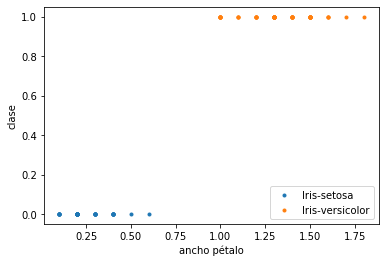

In [3]:
label2index = {'Iris-setosa': 0, 'Iris-versicolor': 1}
x_train = df.values[:100, [3]].astype(np.float32)
y_true_train = df['clase'].map(label2index)[:100].values.astype(np.float32)
plt.plot(x_train[:50], y_true_train[:50], '.', label='Iris-setosa')
plt.plot(x_train[50:], y_true_train[50:], '.', label='Iris-versicolor')
plt.xlabel('ancho pétalo')
plt.ylabel('clase')
plt.legend(loc='lower right');

### Quiz 1

¿Cómo podriamos graficar los cuatro atributos de entrada y contra la salida?

## Tuberia de datos

In [4]:
class PrimerDataset(Dataset):
    
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [5]:
batch_size = 16
ds = PrimerDataset(x_train, y_true_train)
dl = DataLoader(ds, batch_size=batch_size, shuffle=True)

x, y_true = next(iter(dl))
print(f'x={x.numpy()} x.shape={x.shape}')
print(f'y={y_true.numpy()} y_true.shape={y_true.shape}')

x=[[0.2]
 [1.3]
 [0.2]
 [1.3]
 [1.2]
 [1.5]
 [1.4]
 [1.3]
 [0.2]
 [0.2]
 [1.5]
 [0.4]
 [0.2]
 [0.2]
 [1.6]
 [0.2]] x.shape=torch.Size([16, 1])
y=[0. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 0. 0. 0. 1. 0.] y_true.shape=torch.Size([16])


## Definición del modelo

In [6]:
class LogReg(nn.Module):

    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(1, 1)

    def forward(self, x):
        x = self.fc(x)
        return torch.sigmoid(x).squeeze()

### Quiz 2

¿Qué modelo sencillo podríamos usar para realizar clasificación de las tres clases?

## Definición de pérdida y optimizador

In [7]:
model = LogReg()
loss_fn = nn.BCELoss(reduction='none')
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

### Quiz 3

¿Qué función de pérdida podríamos usar para realizar clasificación de las tres clases?

## Definición de métricas

Las funciones de pérdida en PyTorch incluyen un parámetro `reduction` que especifica la reducción que se aplica antes de regresar el resultado. Si usamos `reduction='none'` podemos obtener la pérdida de cada observación y agregarla en la forma que queramos. A continuación calcularemos la pérdida de entrenamiento promedio por época.

### Quiz 4

¿Cómo se define la exactitud?


## Entrenamiento

In [8]:
epochs = 20

for epoch in range(epochs):

    train_loss, train_acc = [], []
    
    for x, y_true in dl:
        optimizer.zero_grad()
        y_pred = model(x)
        loss = loss_fn(y_pred, y_true) # vector
        loss.mean().backward() # se necesita un escalar para calcular gradientes
        optimizer.step()

        train_loss.extend(loss.data.numpy())
        train_acc.extend((y_pred > 0.5).float() == y_true)

    print(f'Epoch: {epoch:>2}. Loss: {np.mean(train_loss):.2f}. Acc={np.mean(train_acc):.2%}')

Epoch:  0. Loss: 0.60. Acc=65.00%
Epoch:  1. Loss: 0.55. Acc=98.00%
Epoch:  2. Loss: 0.52. Acc=100.00%
Epoch:  3. Loss: 0.49. Acc=100.00%
Epoch:  4. Loss: 0.47. Acc=99.00%
Epoch:  5. Loss: 0.45. Acc=99.00%
Epoch:  6. Loss: 0.43. Acc=99.00%
Epoch:  7. Loss: 0.42. Acc=99.00%
Epoch:  8. Loss: 0.41. Acc=99.00%
Epoch:  9. Loss: 0.39. Acc=99.00%
Epoch: 10. Loss: 0.38. Acc=99.00%
Epoch: 11. Loss: 0.37. Acc=99.00%
Epoch: 12. Loss: 0.36. Acc=99.00%
Epoch: 13. Loss: 0.35. Acc=99.00%
Epoch: 14. Loss: 0.34. Acc=99.00%
Epoch: 15. Loss: 0.33. Acc=99.00%
Epoch: 16. Loss: 0.32. Acc=99.00%
Epoch: 17. Loss: 0.32. Acc=99.00%
Epoch: 18. Loss: 0.31. Acc=99.00%
Epoch: 19. Loss: 0.30. Acc=100.00%


## Inferencia

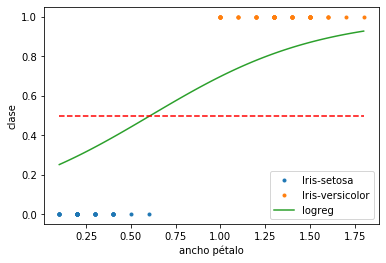

In [9]:
with torch.no_grad():
    xt = torch.linspace(x_train.min(), x_train.max())[:, None]
    y_pred = model(xt).numpy()
    
plt.plot(x_train[:50], y_true_train[:50], '.', label='Iris-setosa')
plt.plot(x_train[50:], y_true_train[50:], '.', label='Iris-versicolor')
plt.plot(xt.numpy(), y_pred, label='logreg')
plt.plot([xt.min(), xt.max()], [0.5, 0.5], 'r--')
plt.xlabel('ancho pétalo')
plt.ylabel('clase')
plt.legend(loc='lower right');

### Quiz 5

¿Qué pasaría con la pérdida, la exactitud y la gráfica de la función sigmoide si entrenamos durante 100 épocas?